## Approach
- Clean and transform data
    - Dataset overview
    - Data type conversion
    - Handling missing values
- Exploratory data analysis
- Compare pricing strategy performance
- Analyze price elasticity
    - Compare the price elasticity of the strategies in the dataset
    - Compare the price elasticity within each group
- Pick the best pricing model
    - Statistical point of view
    - Price point of view
    - Bias check for one  category columns as sample
- Explore relationship between conversion and claims
- Model comparison  
- Final recommendation

## Setup

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.stats import kruskal

In [2]:
# quality-of-life
pd.options.mode.use_inf_as_na = True
plt.style.use("ggplot")
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
df = pd.read_csv("PA-Dataset.csv")

## Clean and transform data

### Dataset Overview

In [4]:
df.shape

(8867, 21)

In [5]:
df.columns

Index(['offerdate', 'sold_premium', 'offered_premium', 'purchase_price',
       'purchase_date', 'item age', 'pricing_point', 'predictedconversionrate',
       'plan_flag', 'plan_count', 'plansactive_lastyear_count',
       'planscancelled_lastyear_count', 'claims_count', 'claim_amount',
       'price_diff', 'IsModel', 'sale_flag', 'base_rate',
       'manufacturerbrandname_enc', 'itemcategoryname_enc',
       'itemsupercategorycode_enc'],
      dtype='object')

In [6]:
# Rename columns for consistency
df = df.rename(columns={
'item age': 'item_age',
'offerdate': 'offer_date',
'predictedconversionrate': 'predicted_conversion_rate',
'IsModel': 'is_model',
'manufacturerbrandname_enc': 'manufacturer_brandname_enc',
'itemcategoryname_enc': 'item_category_name_enc',
'itemsupercategorycode_enc':'item_supercategory_code_enc'
}) 

In [7]:
df.head()

,offer_date,sold_premium,offered_premium,purchase_price,purchase_date,item_age,pricing_point,predicted_conversion_rate,plan_flag,plan_count,...,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,is_model,sale_flag,base_rate,manufacturer_brandname_enc,item_category_name_enc,item_supercategory_code_enc
0,17/03/2023,NaN,32.64,89.99,16/03/2023,1,@22%,0.15,0,0.0,...,0.0,0.0,0.00,-0.058824,Yes,0,34.68,56,35,14
1,01/03/2023,69.72,69.72,329.00,24/12/2022,67,@22%,0.81,1,5.0,...,2.0,4.0,347.12,-0.023529,Yes,1,71.40,123,34,3
2,12/04/2023,NaN,48.24,249.00,05/04/2023,7,@23%,0.08,0,0.0,...,0.0,0.0,0.00,0.210843,Yes,0,39.84,7,16,12
3,09/03/2023,NaN,91.92,746.42,09/03/2021,730,@23%,0.32,0,0.0,...,0.0,0.0,0.00,0.298305,Yes,0,70.80,107,36,4
4,18/03/2023,NaN,89.64,493.98,18/03/2023,0,@22%,0.25,1,1.0,...,0.0,0.0,0.00,0.299130,Yes,0,69.00,57,36,4


In [8]:
df.tail()

,offer_date,sold_premium,offered_premium,purchase_price,purchase_date,item_age,pricing_point,predicted_conversion_rate,plan_flag,plan_count,...,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,is_model,sale_flag,base_rate,manufacturer_brandname_enc,item_category_name_enc,item_supercategory_code_enc
8862,10/04/2023,NaN,69.72,275.00,08/04/2023,2,@23%,0.11,0,0.0,...,0.0,0.0,0.0,0.094162,Yes,0,63.72,7,37,4
8863,30/03/2023,69.72,69.72,262.14,23/03/2023,7,@22%,0.14,0,0.0,...,0.0,NaN,NaN,0.218029,Yes,1,57.24,74,34,3
8864,21/03/2023,NaN,48.12,280.00,21/03/2023,0,@22%,0.12,0,0.0,...,0.0,0.0,0.0,-0.012315,Yes,0,48.72,62,12,4
8865,10/03/2023,NaN,69.72,550.00,09/03/2023,1,@22%,0.31,1,1.0,...,1.0,NaN,NaN,0.249462,Yes,0,55.80,74,37,4
8866,30/03/2023,53.40,53.40,300.00,16/01/2023,73,@22%,0.11,0,0.0,...,0.0,0.0,0.0,0.297376,Yes,1,41.16,12,16,12


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8867 entries, 0 to 8866
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   offer_date                     8867 non-null   object 
 1   sold_premium                   1991 non-null   float64
 2   offered_premium                8867 non-null   float64
 3   purchase_price                 8866 non-null   float64
 4   purchase_date                  8867 non-null   object 
 5   item_age                       8867 non-null   object 
 6   pricing_point                  8867 non-null   object 
 7   predicted_conversion_rate      8867 non-null   float64
 8   plan_flag                      8867 non-null   int64  
 9   plan_count                     8826 non-null   float64
 10  plansactive_lastyear_count     8826 non-null   float64
 11  planscancelled_lastyear_count  8826 non-null   float64
 12  claims_count                   7718 non-null   f

In [10]:
df.describe()

,sold_premium,offered_premium,purchase_price,predicted_conversion_rate,plan_flag,plan_count,plansactive_lastyear_count,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,sale_flag,base_rate,manufacturer_brandname_enc,item_category_name_enc,item_supercategory_code_enc
count,1991.000000,8867.000000,8866.000000,8867.000000,8867.000000,8826.000000,8826.000000,8826.000000,7718.000000,7718.000000,8867.000000,8867.000000,8867.000000,8867.000000,8867.000000,8867.000000
mean,53.085445,53.029268,406.714300,0.315993,0.197135,0.409245,0.683889,0.232948,0.210935,29.233799,0.080764,0.224540,49.090976,53.764746,22.601218,4.677117
std,15.115377,16.273887,214.171991,0.298250,0.397858,1.033808,1.966232,0.982052,0.896236,187.440800,0.129798,0.417303,13.565841,38.936852,10.902879,3.894367
min,18.600000,12.720000,19.990000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.298643,0.000000,18.000000,-1.000000,0.000000,0.000000
25%,45.120000,45.000000,295.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.480000,16.000000,12.000000,2.000000
50%,48.240000,48.120000,330.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069149,0.000000,45.960000,57.000000,19.000000,4.000000
75%,63.360000,63.600000,472.085000,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169096,0.000000,59.640000,74.000000,36.000000,4.000000
max,150.000000,150.000000,1200.000000,1.000000,1.000000,5.000000,32.000000,25.000000,30.000000,10523.030000,0.299886,1.000000,150.000000,130.000000,37.000000,16.000000


### Data type conversion

In [11]:
# Convert date columns to datetime format
df['purchase_date']  = pd.to_datetime(df['purchase_date'], dayfirst=True)
df['offer_date']     = pd.to_datetime(df['offer_date'], dayfirst=True)

In [12]:
# Update int columns format
df['is_model']= df['is_model'].map({'Yes': 1, 'No': 0}).astype(int)

In [13]:
#update categorical columns format
columns_to_convert = ['manufacturer_brandname_enc','item_supercategory_code_enc','item_category_name_enc','pricing_point']
for column in columns_to_convert:
    df[column] = df[column].astype('category')

In [14]:
#update integer columns format
columns_to_convert = ['planscancelled_lastyear_count', 'plansactive_lastyear_count', 'claims_count', 'plan_count']
for column in columns_to_convert:
    df[column] = df[column].astype('Int64')

In [15]:
# Updateing 'item_age' calculation (likely swapped dates)
swap_condition = df['purchase_date'] > df['offer_date']

# Swap 'offer_date' and 'purchase_date' where purchase_date is greater than offer_date
for idx in df[swap_condition].index:
    temp = df.at[idx, 'offer_date']
    df.at[idx, 'offer_date'] = df.at[idx, 'purchase_date']
    df.at[idx, 'purchase_date'] = temp

# Recalculate item age
df['item_age'] = (df['offer_date'] - df['purchase_date']).dt.days
df['item_age'] = df['item_age'].astype('Int64')

### handling missing values

In [16]:
df.isna().sum()

offer_date                          0
sold_premium                     6876
offered_premium                     0
purchase_price                      1
purchase_date                       0
item_age                            0
pricing_point                       0
predicted_conversion_rate           0
plan_flag                           0
plan_count                         41
plansactive_lastyear_count         41
planscancelled_lastyear_count      41
claims_count                     1149
claim_amount                     1149
price_diff                          0
is_model                            0
sale_flag                           0
base_rate                           0
manufacturer_brandname_enc          0
item_category_name_enc              0
item_supercategory_code_enc         0
dtype: int64

Text(0.5, 1.0, 'Missing Values Matrix')

<Figure size 1200x600 with 0 Axes>

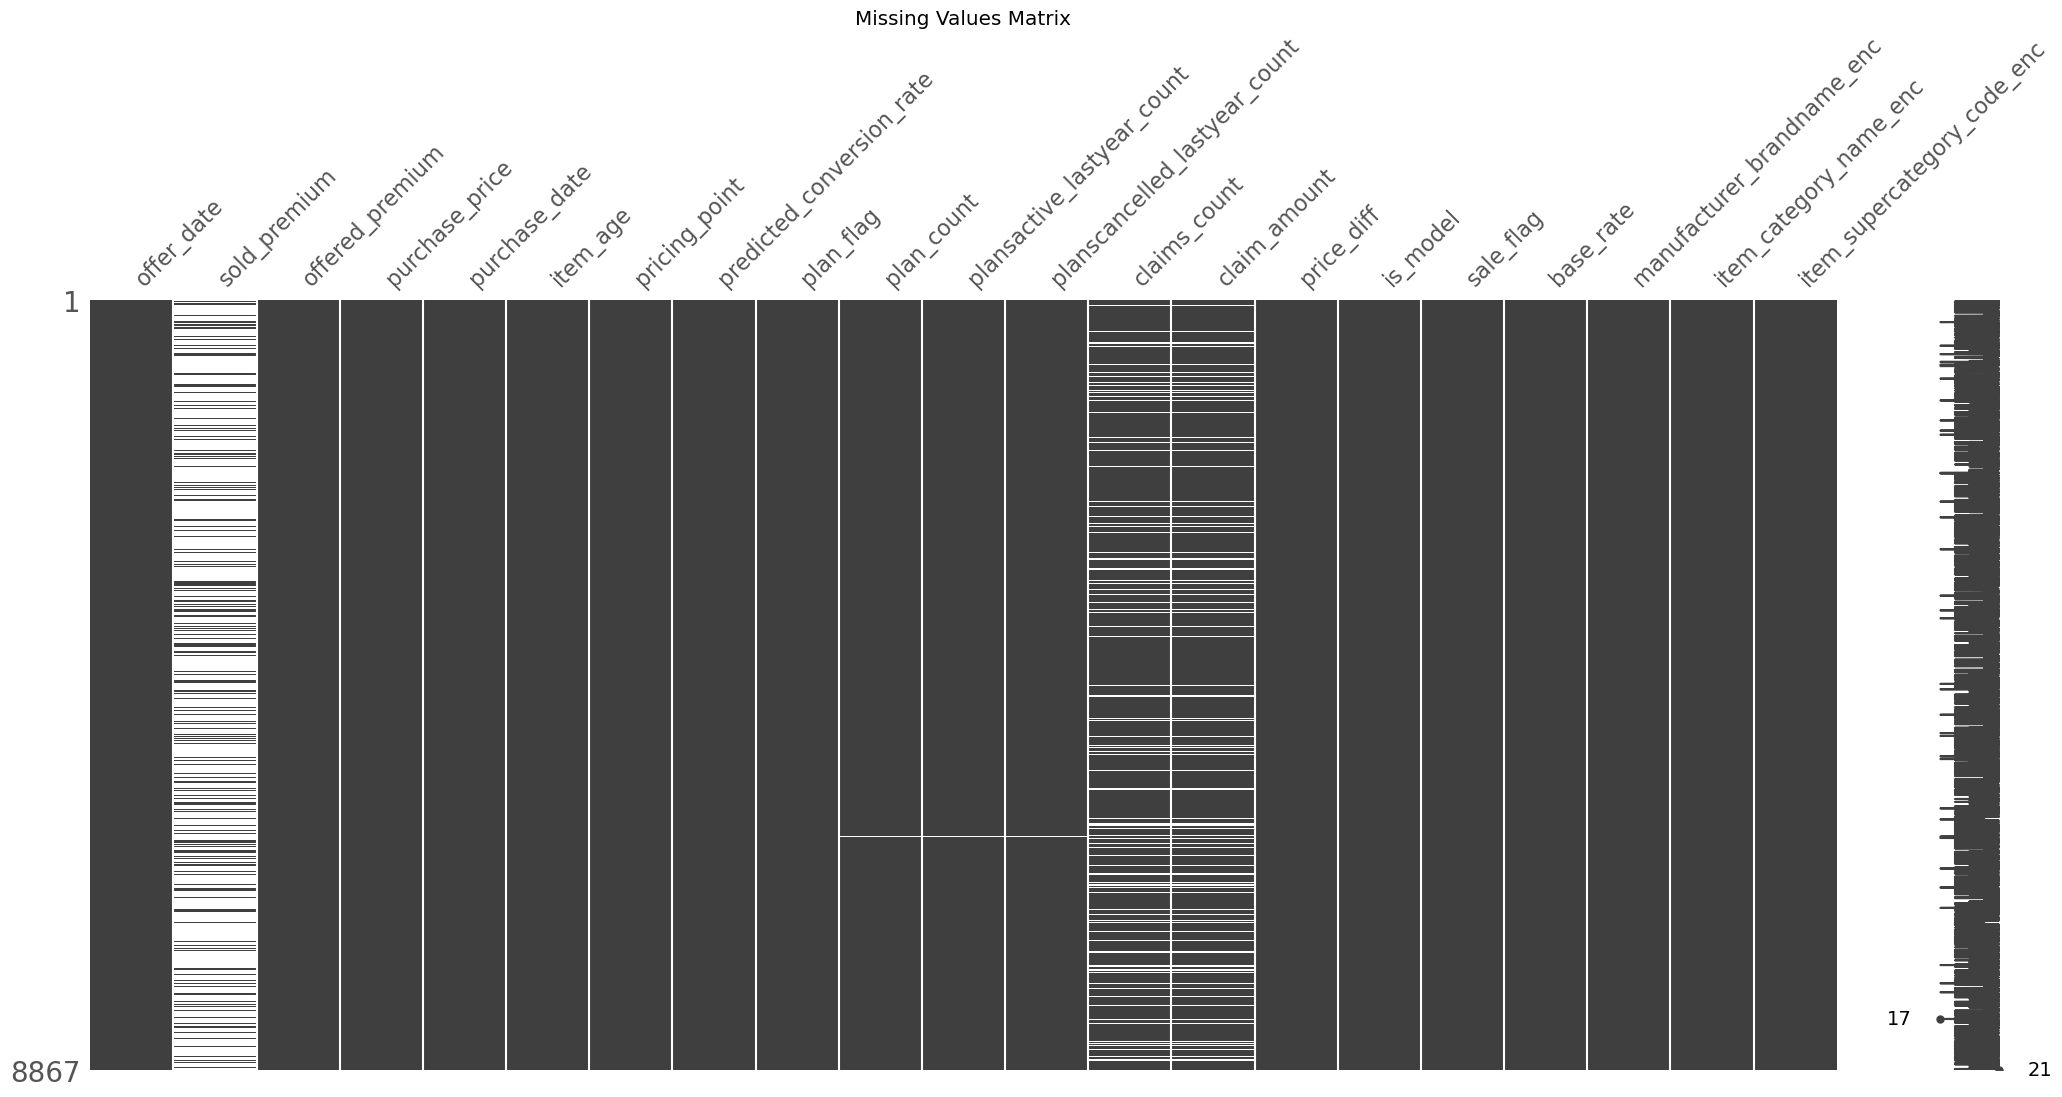

In [17]:
# Visualize missing values
plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.title('Missing Values Matrix')

<Axes: >

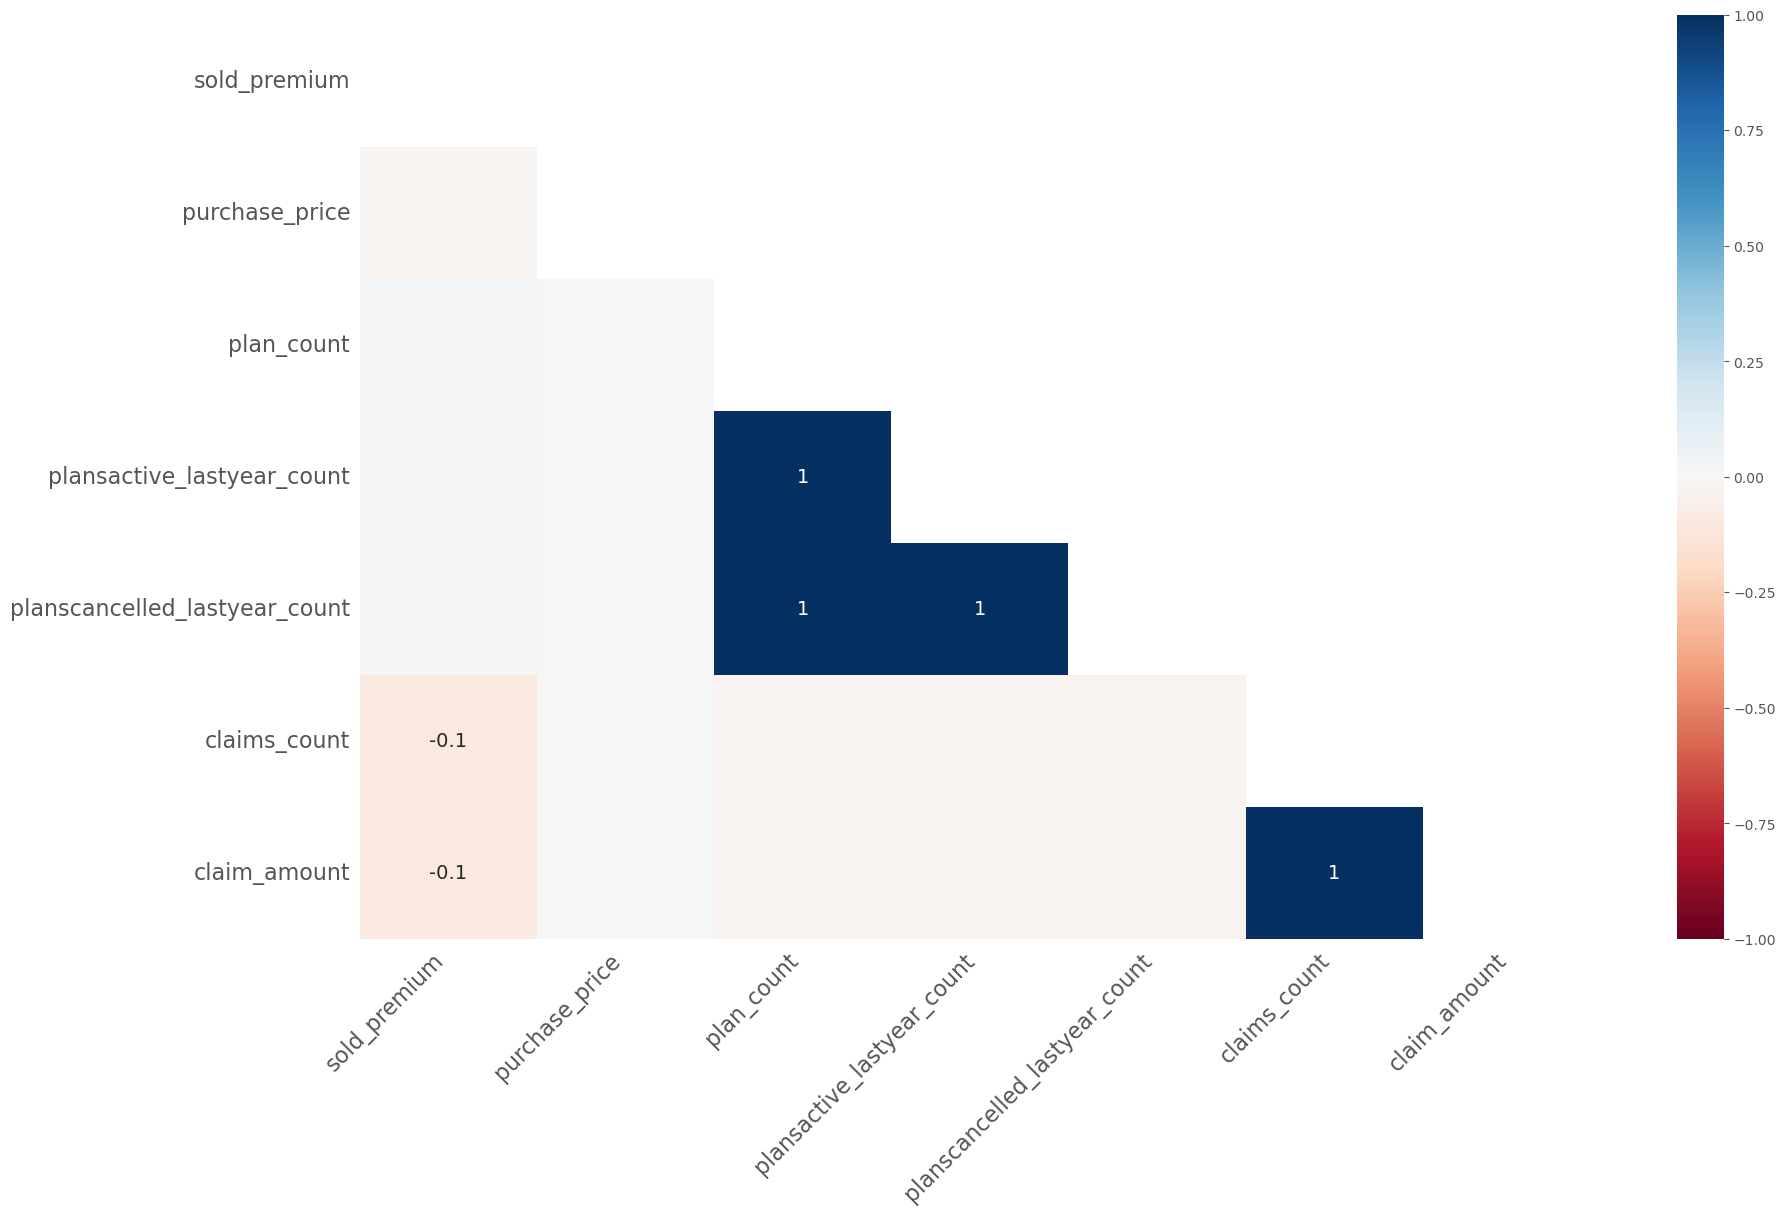

In [ ]:
# Visualize missing values correlation
msno.heatmap(df)

- Check for missing values in 'purchase_price'

In [19]:
df[df['purchase_price'].isnull()]

,offer_date,sold_premium,offered_premium,purchase_price,purchase_date,item_age,pricing_point,predicted_conversion_rate,plan_flag,plan_count,...,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,is_model,sale_flag,base_rate,manufacturer_brandname_enc,item_category_name_enc,item_supercategory_code_enc
2706,2023-04-20,40.2,40.2,NaN,2023-04-04,16,@22%,0.58,1,4,...,0,2,795.0,0.073718,1,1,37.44,123,24,2


In [ ]:
# looking for posible simillar items to imputing it by finding similar products
df[(df['manufacturer_brandname_enc'] == 123) & (df['item_category_name_enc'] == 24)]

,offer_date,sold_premium,offered_premium,purchase_price,purchase_date,item_age,pricing_point,predicted_conversion_rate,plan_flag,plan_count,...,planscancelled_lastyear_count,claims_count,claim_amount,price_diff,is_model,sale_flag,base_rate,manufacturer_brandname_enc,item_category_name_enc,item_supercategory_code_enc
2706,2023-04-20,40.2,40.2,NaN,2023-04-04,16,@22%,0.58,1,4,...,0,2,795.0,0.073718,1,1,37.44,123,24,2


In [ ]:
# drop rows with missing purchase_price
df = df.dropna(subset=['purchase_price'])

- Check for missing values in 'sold_premium'

In [22]:
df['sold_premium'].isnull().value_counts()

sold_premium
True     6876
False    1990
Name: count, dtype: int64

In [ ]:
# Looking for posible Issues with sold_premium and sale_flag
len(df[df['sold_premium'].notnull() & (df['sale_flag'] != 1)])

0

In [24]:
len(df[(df['sold_premium'].isnull()) & (df['sale_flag'] == 1)])

0

- Check for missing values in plan_count &  plansactive_lastyear_count & planscancelled_lastyear_count

In [25]:
# Looking at their indexes for possilbe issues
df[df['plan_count'].isnull()].index

Index([ 254,  526,  623,  712,  745,  760,  905, 1156, 1386, 1503, 1551, 1990,
       1996, 2321, 2502, 2870, 3404, 3573, 3664, 3868, 4420, 4482, 4775, 4986,
       5019, 5254, 5285, 5853, 5980, 6027, 6178, 6194, 6545, 6764, 6999, 7564,
       7657, 7867, 7874, 7970, 8278],
      dtype='int64')

In [ ]:
 # Looking at the distribution of plan-related columns also (plansactive_lastyear_count,planscancelled_lastyear_count)
df['plan_count'].value_counts(normalize=True)  

plan_count
0     0.80204
1    0.104249
2    0.037167
5    0.024136
3    0.020057
4    0.012351
Name: proportion, dtype: Float64

In [ ]:
# Fill NaN values in plan-related columns with 0 (it makes sense to assume that missing values here simply mean the customer has no plans)
Na_plan_columns = ['planscancelled_lastyear_count', 'plansactive_lastyear_count', 'plan_count']
df[Na_plan_columns] = df[Na_plan_columns].fillna(0)

- Check for missing values in 'claims_count' and 'amount_count'

In [28]:
df['claims_count'].isnull().value_counts(normalize=True)

claims_count
False    0.870404
True     0.129596
Name: proportion, dtype: float64

In [29]:
df['claims_count'].dropna().value_counts(normalize=True)

claims_count
0     0.898017
1     0.052482
2     0.024103
3     0.012181
4     0.006609
5     0.002851
6     0.001814
7     0.000907
8     0.000389
21     0.00013
11     0.00013
30     0.00013
10     0.00013
24     0.00013
Name: proportion, dtype: Float64

In [30]:
df[df['claims_count'].isnull()]['sale_flag'].value_counts()

sale_flag
0    765
1    384
Name: count, dtype: int64

In [ ]:
# Create a missing flag to track missing claims during analysis
df['missing_claims_flag'] = df['claims_count'].isnull().astype(int)

In [32]:
# Grouping potentially relevant columns to be used in the imputation
impute_cols = [
    'claims_count', 
    'claim_amount',
    'plan_count',
    'plansactive_lastyear_count',
    'planscancelled_lastyear_count',
    'purchase_price',
    'item_age',
    'sale_flag'
]
impute_df = df[impute_cols]

In [ ]:
# Perform MICE imputation Reason: (multiple variables, Missing at Random, signicat but not Excessive Missingness)
imputer = IterativeImputer(random_state=0, max_iter=10)

imputed_array = imputer.fit_transform(impute_df)

df[impute_cols] = imputed_array

In [34]:
# Round to nearest integer
df['claims_count'] = df['claims_count'].round().astype('Int64')

In [35]:
# Set claim_amount to 0.0 where claims_count is 0
df.loc[df['claims_count'] == 0, 'claim_amount'] = 0.0

In [36]:
# Check the distribution of claims_count after imputation
df.loc[df['missing_claims_flag'] == 1, 'claims_count'].value_counts()

claims_count
0    872
1    233
2     38
3      6
Name: count, dtype: Int64

In [37]:
# validating the imputation
df[(df['missing_claims_flag'] == 1) & (df['claims_count'] == 3)]

,offer_date,sold_premium,offered_premium,purchase_price,purchase_date,item_age,pricing_point,predicted_conversion_rate,plan_flag,plan_count,...,claims_count,claim_amount,price_diff,is_model,sale_flag,base_rate,manufacturer_brandname_enc,item_category_name_enc,item_supercategory_code_enc,missing_claims_flag
1733,2023-03-25,69.36,69.36,311.00,2023-03-03,22.0,@23%,0.51,1,2.0,...,3,431.699301,0.090566,1,1.0,63.60,57,37,4,1
2485,2023-03-01,NaN,48.12,329.98,2021-12-06,450.0,@22%,0.58,1,4.0,...,3,425.898539,0.297735,1,0.0,37.08,129,25,2,1
3335,2023-03-25,40.68,40.68,250.00,2023-03-25,0.0,@23%,0.52,1,3.0,...,3,361.924159,-0.011662,1,1.0,41.16,7,12,4,1
4498,2023-03-16,69.72,69.72,419.00,2023-03-09,7.0,@22%,0.61,1,5.0,...,3,339.258607,0.030142,1,1.0,67.68,57,37,4,1
4647,2023-04-13,NaN,48.24,279.00,2023-04-08,5.0,@23%,0.32,0,0.0,...,3,464.363902,0.049608,1,0.0,45.96,62,11,1,1
4944,2023-03-07,NaN,82.08,400.00,2021-03-07,730.0,@23%,0.56,1,5.0,...,3,331.727005,0.297913,1,0.0,63.24,107,37,4,1


In [77]:
# viduale validity of imputation
df.loc[df['plansactive_lastyear_count'] >7,'claims_count'].value_counts()

claims_count
3     34
2     33
1     23
0     22
4     13
5     12
6      7
7      6
8      3
21     1
11     1
30     1
10     1
24     1
Name: count, dtype: Int64

In [ ]:
# viduale validity of imputation
df.loc[df['planscancelled_lastyear_count'] >4,'claims_count'].value_counts()

claims_count
2     29
3     17
1     14
0     10
4      8
7      5
5      4
8      2
21     1
6      1
11     1
30     1
10     1
24     1
Name: count, dtype: Int64

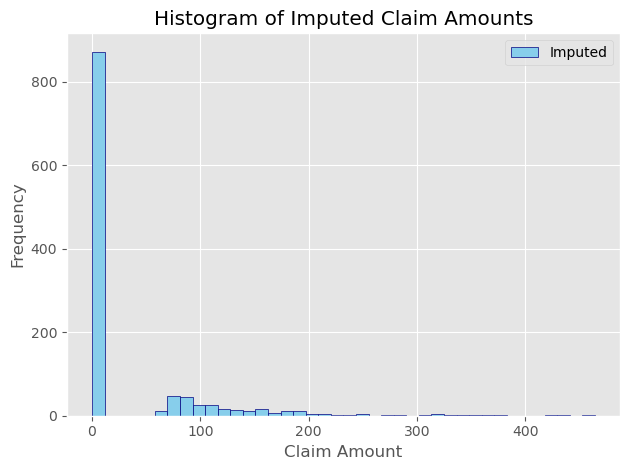

In [78]:
# Visualize the distribution of imputed claim amounts
df[df['missing_claims_flag'] == 1]['claim_amount'].hist(bins=40, label='Imputed',color='skyblue', edgecolor='navy')
plt.legend()
plt.title('Histogram of Imputed Claim Amounts')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.tight_layout()

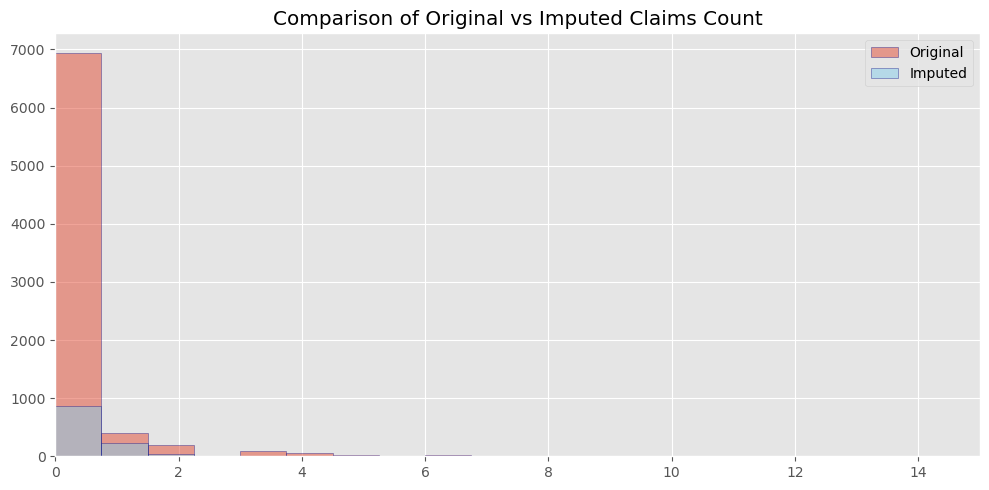

In [81]:
# Compare the distribution of original vs imputed claims count
plt.figure(figsize=(10,5))
df[df['missing_claims_flag'] == 0]['claims_count'].hist(bins=40, alpha=0.5, label='Original', edgecolor='navy')
df[df['missing_claims_flag'] == 1]['claims_count'].hist(bins=4, alpha=0.5,color='skyblue', label='Imputed',edgecolor='navy')

plt.xlim(0, 15)
plt.legend()
plt.title('Comparison of Original vs Imputed Claims Count')
plt.tight_layout()

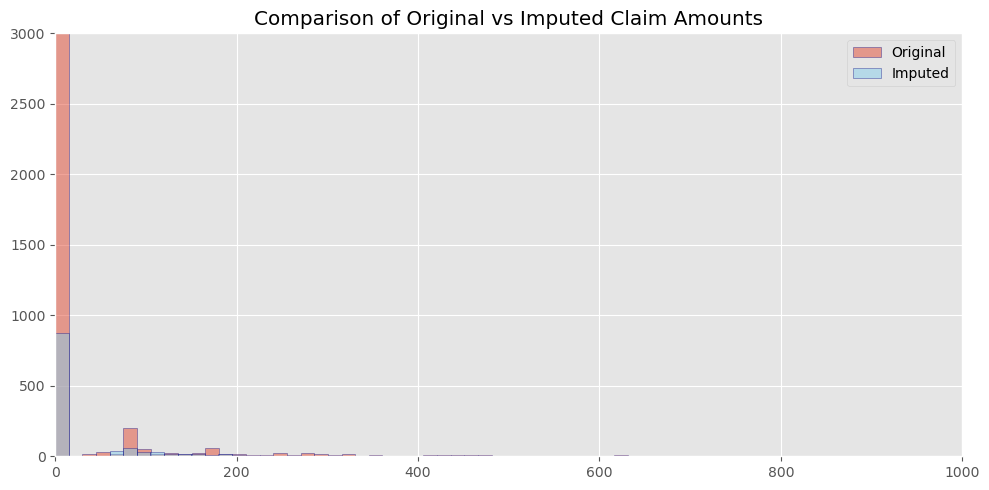

In [82]:
# Compare the distribution of original vs imputed claims Amounts
plt.figure(figsize=(10,5))
df[df['missing_claims_flag'] == 0]['claim_amount'].hist(bins=700, alpha=0.5, label='Original', edgecolor='navy')
df[df['missing_claims_flag'] == 1]['claim_amount'].hist(bins=31, alpha=0.5,color='skyblue', label='Imputed', edgecolor='navy')
plt.legend()
plt.xlim(0, 1000)
plt.ylim(0, 3000)
plt.title('Comparison of Original vs Imputed Claim Amounts')
plt.tight_layout()

## Exploratory data analysis

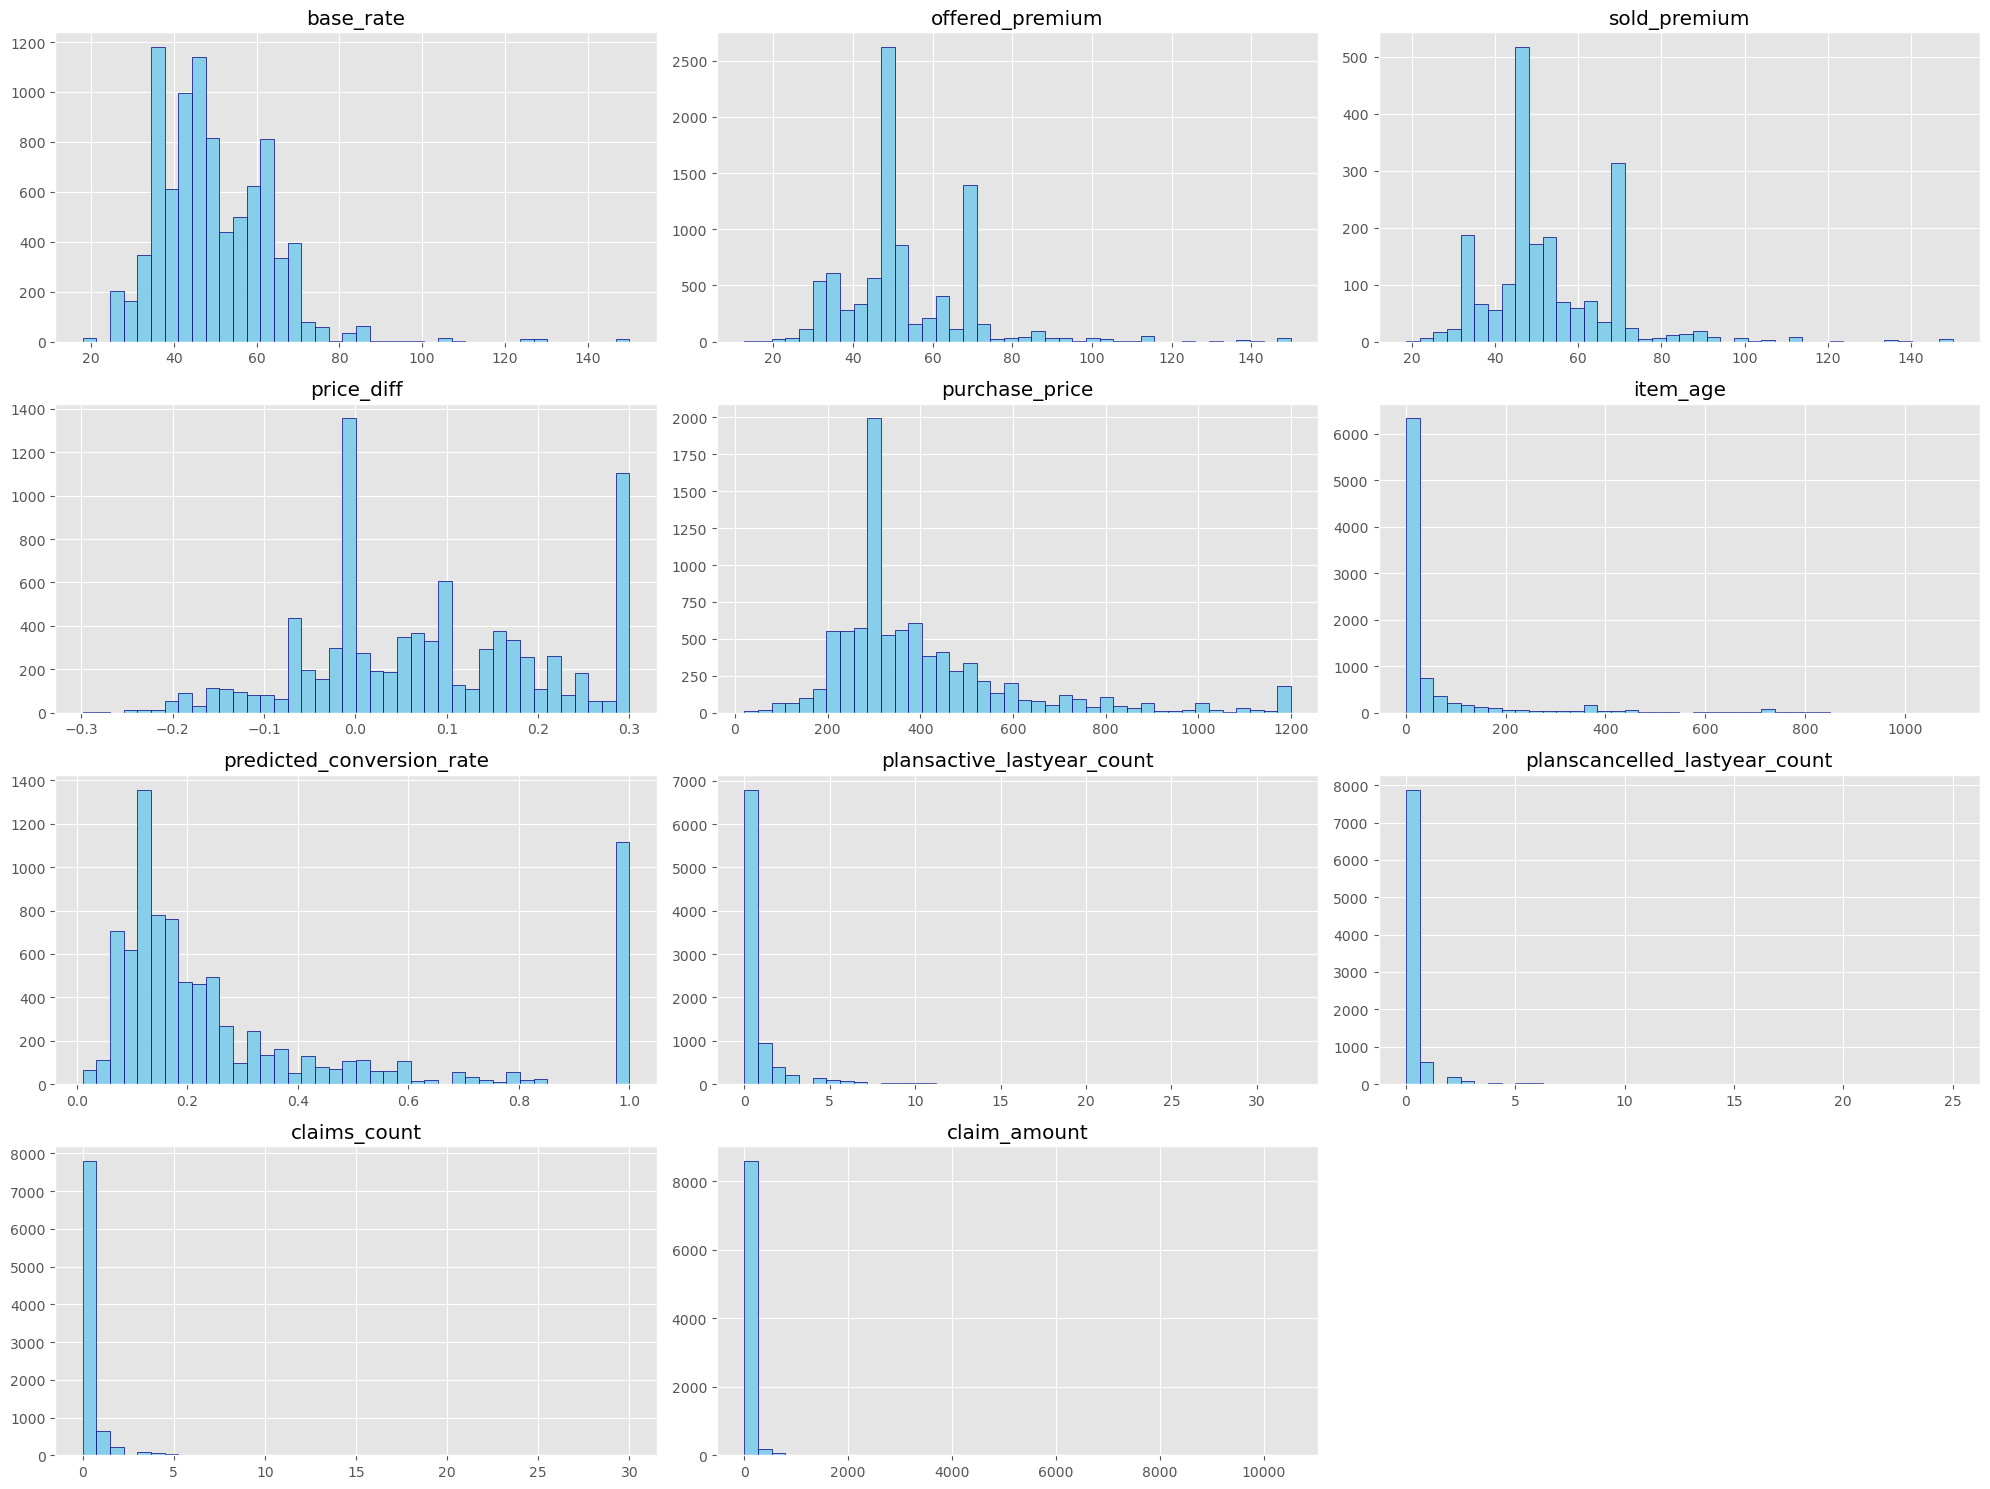

In [43]:
# numerical columns visualization
num_cols = ['base_rate', 'offered_premium', 'sold_premium', 'price_diff', 'purchase_price', 'item_age','predicted_conversion_rate','plansactive_lastyear_count','planscancelled_lastyear_count','claims_count','claim_amount']
df[num_cols].hist(bins=40, figsize=(20,15),color='skyblue', edgecolor='navy')
plt.tight_layout()

In [44]:
# age column percentiles
percentiles = [0.25, 0.5,  0.75, 0.90, 0.95, 0.99, 1.0]
summary = df['item_age'].quantile(percentiles)
summary.index = [f"{int(p*100)}%" for p in summary.index]
summary


25%        1.0
50%        7.0
75%       33.0
90%      174.0
95%      365.0
99%      730.0
100%    1096.0
Name: item_age, dtype: float64

In [45]:
# claim amount column percentiles
percentiles = [0.25, 0.5,  0.75, 0.90, 0.95, 0.99, 1.0]
summary = df.loc[df['claims_count'] > 0]['claim_amount'].quantile(percentiles)
summary.index = [f"{int(p*100)}%" for p in summary.index]
summary

25%        85.0300
50%       133.0900
75%       263.8150
90%       487.5530
95%       715.0795
99%      1654.6870
100%    10523.0300
Name: claim_amount, dtype: float64

In [46]:
# claim count column percentiles
percentiles = [0.25, 0.5,  0.75, 0.90, 0.95, 0.99, 1.0]
summary = df['claims_count'].quantile(percentiles)
summary.index = [f"{int(p*100)}%" for p in summary.index]
summary

25%      0.0
50%      0.0
75%      0.0
90%      1.0
95%      1.0
99%      4.0
100%    30.0
Name: claims_count, dtype: Float64

In [47]:
# Summary table for plan_flag
counts = df['plan_flag'].value_counts()
percentages = df['plan_flag'].value_counts(normalize=True)
summary_table = pd.DataFrame({'Count': counts,'Percentage': percentages})
summary_table['Percentage'] = (summary_table['Percentage'] * 100).round(2).astype(str) + '%'
summary_table

,Count,Percentage
plan_flag,,
0,7119,80.3%
1,1747,19.7%


In [48]:
# Summary table for is_model
counts = df['is_model'].value_counts()
percentages = df['is_model'].value_counts(normalize=True)
summary_table = pd.DataFrame({'Count': counts,'Percentage': percentages})
summary_table['Percentage'] = (summary_table['Percentage'] * 100).round(2).astype(str) + '%'
summary_table

,Count,Percentage
is_model,,
1,7749,87.4%
0,1117,12.6%


In [49]:
# Summary table for sale_flag
counts = df['sale_flag'].value_counts()
percentages = df['sale_flag'].value_counts(normalize=True)
summary_table = pd.DataFrame({'Count': counts,'Percentage': percentages})
summary_table['Percentage'] = (summary_table['Percentage'] * 100).round(2).astype(str) + '%'
summary_table

,Count,Percentage
sale_flag,,
0.0,6876,77.55%
1.0,1990,22.45%


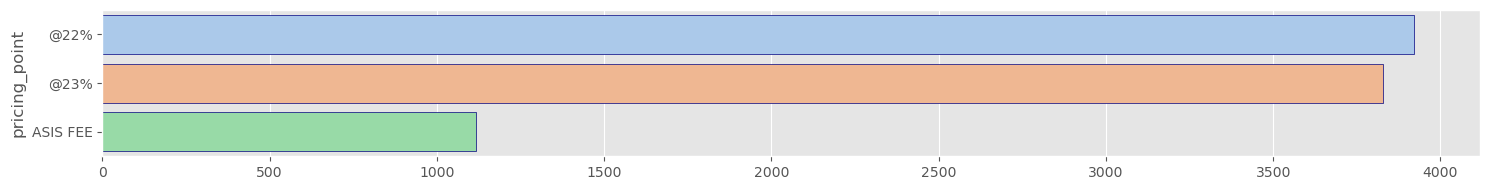

In [83]:
# pricing_point columns visualization
plt.figure(figsize=(15, 2))
counts = df['pricing_point'].value_counts()
sns.barplot(x=counts.values,y=counts.index,palette='pastel',edgecolor='navy',)
plt.tight_layout()

In [51]:
# Summary table for pricing_point
df.groupby('pricing_point')[['base_rate', 'offered_premium', 'sold_premium', 'price_diff','sale_flag']].mean()


,base_rate,offered_premium,sold_premium,price_diff,sale_flag
pricing_point,,,,,
@22%,49.203957,55.216430,55.768714,0.124335,0.220041
@23%,49.014236,51.976650,51.482768,0.059686,0.226548
ASIS FEE,48.967628,48.967628,49.572923,0.000000,0.232766


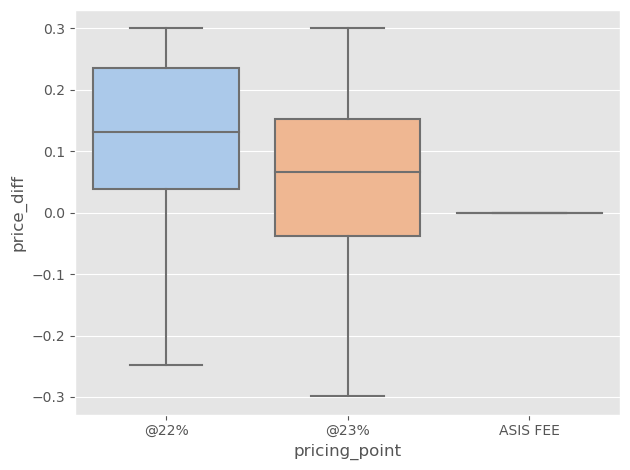

In [52]:
# Visualize the distribution of price differences by pricing point
sns.boxplot(x='pricing_point',palette='pastel', y='price_diff', data=df)
plt.tight_layout()

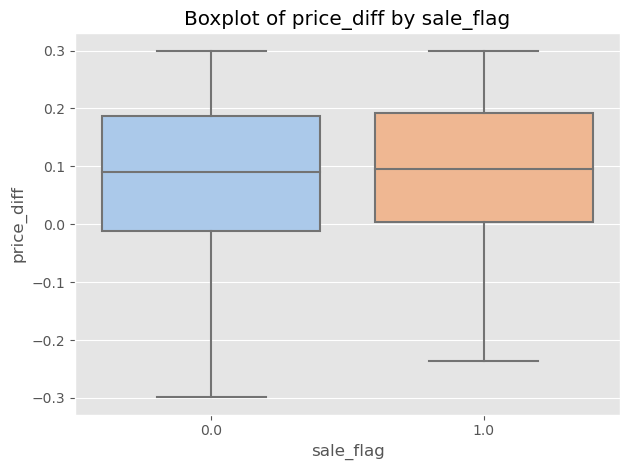

In [97]:
# Visualize the distribution of price differences by sale_flag
sns.boxplot(x='sale_flag', y='price_diff', data=df[df['is_model'] == 1], palette='pastel', showfliers=True)
plt.title('Boxplot of price_diff by sale_flag')
plt.tight_layout()

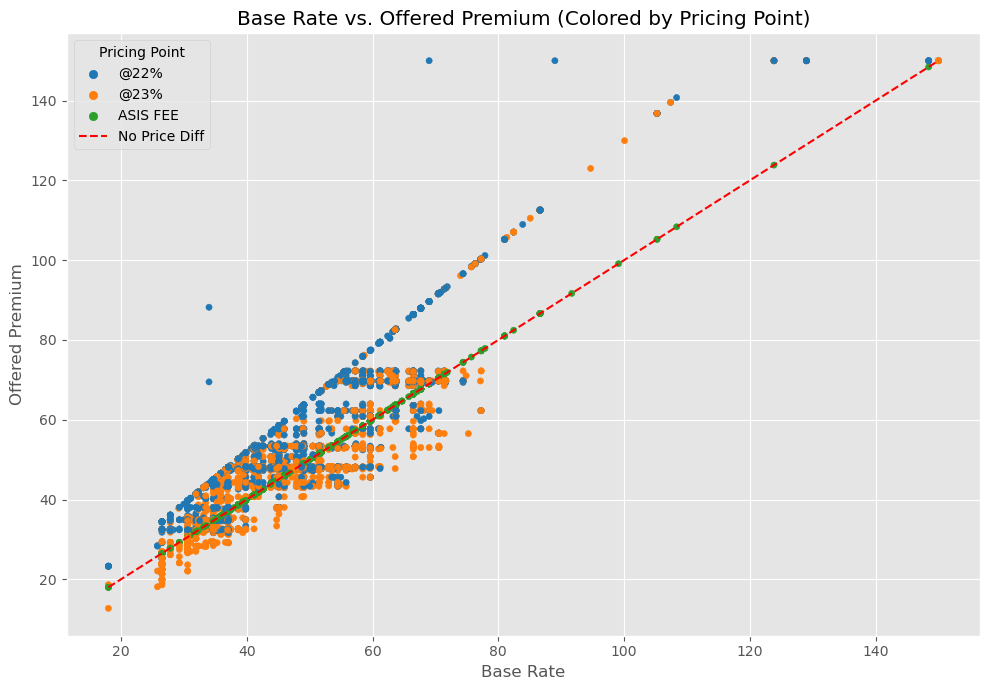

In [54]:
# Scatter plot of base_rate vs offered_premium

plt.figure(figsize=(10,7))

sns.scatterplot(
    x='base_rate',
    y='offered_premium',
    hue='pricing_point', 
    palette='tab10',   
    data=df,
    s=20,
    edgecolor=None
)

# Reference y=x line
plt.plot([df['base_rate'].min(), df['base_rate'].max()], 
         [df['base_rate'].min(), df['base_rate'].max()], 
         'r--', label='No Price Diff')

plt.title('Base Rate vs. Offered Premium (Colored by Pricing Point)')
plt.xlabel('Base Rate')
plt.ylabel('Offered Premium')
plt.legend(title='Pricing Point')
plt.tight_layout()

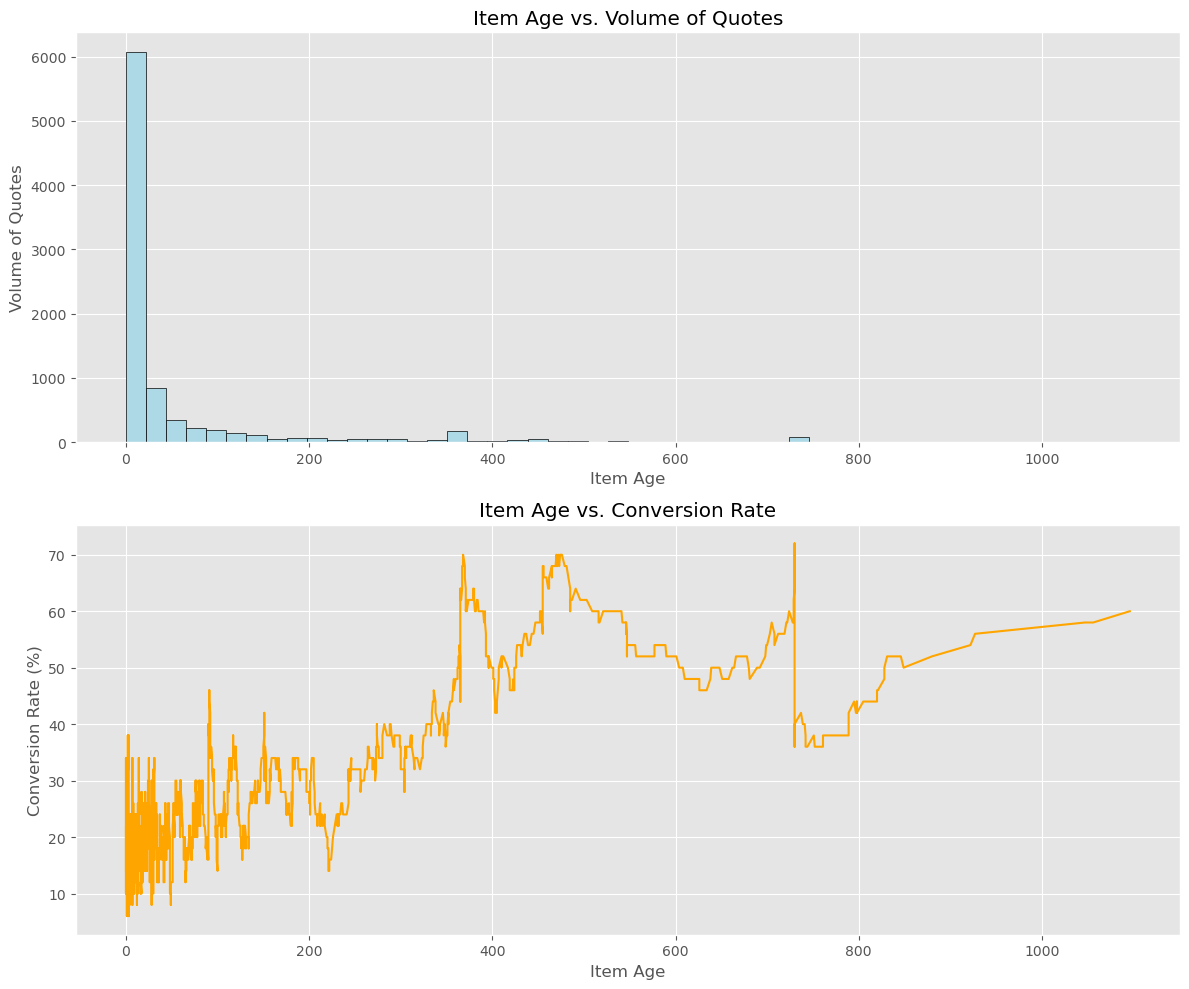

In [84]:
# plot of Age vs quotes and conversion rate
df_sorted = df.sort_values('item_age')
df_sorted['Rolling_Conversion_Rate'] = df_sorted['sale_flag'].rolling(window=50).mean() * 100

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Item Age vs. Volume of Quotes
axes[0].hist(df['item_age'], bins=50, color='lightblue', edgecolor='black')
axes[0].set_xlabel('Item Age')
axes[0].set_ylabel('Volume of Quotes')
axes[0].set_title('Item Age vs. Volume of Quotes')

# Item Age vs. Conversion Rate
axes[1].plot(df_sorted['item_age'], df_sorted['Rolling_Conversion_Rate'], color='orange')
axes[1].set_xlabel('Item Age')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].set_title('Item Age vs. Conversion Rate')
plt.tight_layout()

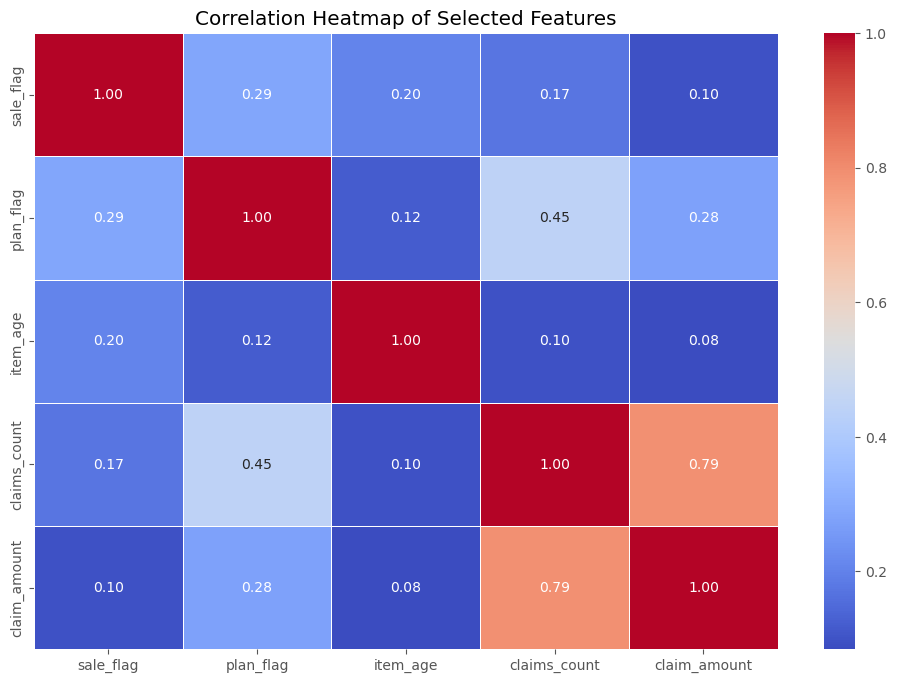

In [56]:
# Correlation heatmap
selected_cols = ['sale_flag', 'plan_flag', 'item_age', 'claims_count', 'claim_amount']
df_subset = df[selected_cols]

# Plot correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_subset.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()


## Compare pricing strategy performance

In [ ]:
# Summary table for pricing strategies 

no_of_offers = df['pricing_point'].value_counts()
average_base_offered = df.groupby('pricing_point')['base_rate'].mean().round(2)
average_price_increase = (df.groupby('pricing_point')['price_diff'].mean() * 100).round(2)
average_sold_premium = df[df['sale_flag'] == 1].groupby('pricing_point')['sold_premium'].mean().round(2)
conversion_rate = (df.groupby('pricing_point')['sale_flag'].mean()* 100).round(2) 

pricing_summary = pd.DataFrame({
    'No of Offers': no_of_offers,
    'Average Base offered': average_base_offered.astype(str) + ' £',
    'Average Price Diff': average_price_increase.astype(str) + ' %',
    'Average Sold Premium': average_sold_premium.astype(str) + ' £',
    'Conversion Rate (%)': conversion_rate.astype(str) + ' %'
})

pricing_summary.reset_index(inplace=True)
pricing_summary

,pricing_point,No of Offers,Average Base offered,Average Price Diff,Average Sold Premium,Conversion Rate (%)
0,@22%,3922,49.2 £,12.43 %,55.77 £,22.0 %
1,@23%,3827,49.01 £,5.97 %,51.48 £,22.65 %
2,ASIS FEE,1117,48.97 £,0.0 %,49.57 £,23.28 %


- Testing if Conversion Rates are significantly different across pricing strategies

In [ ]:
# Chi-squared  to check if conversion rates are significantly different across pricing strategies
contingency_table = pd.crosstab(df['pricing_point'], df['sale_flag'])

# Perform Chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
contingency_table, conversion_rate, chi2, p

(sale_flag       0.0  1.0
 pricing_point           
 @22%           3059  863
 @23%           2960  867
 ASIS FEE        857  260,
 pricing_point
 @22%        22.00
 @23%        22.65
 ASIS FEE    23.28
 Name: sale_flag, dtype: float64,
 0.9786051268215021,
 0.6130538112780947)

- Testing if price dif is significantly different across pricing strategies (@22 and @23)

In [59]:
# Filter only @22% and @23% pricing points
price_diff_22 = df[df['pricing_point'] == '@22%']['price_diff']
price_diff_23 = df[df['pricing_point'] == '@23%']['price_diff']

Text(0.5, 1.0, 'Comparison of pricing_points')

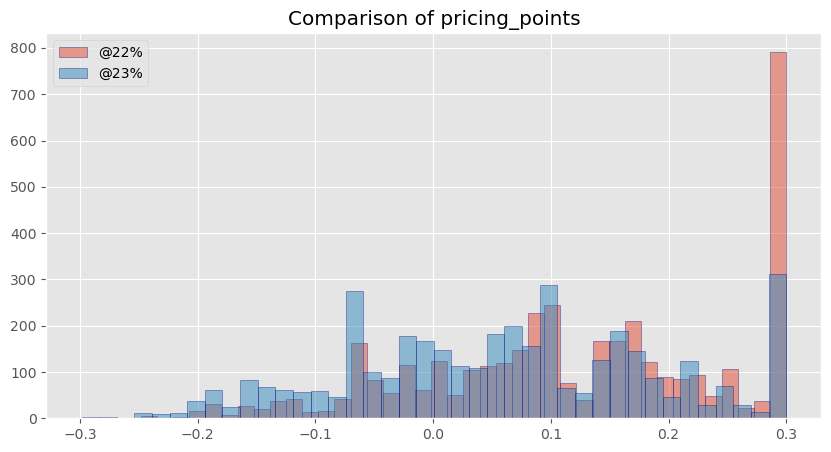

In [60]:
# checking the distribution of price differences for @22% and @23%
plt.figure(figsize=(10,5))
price_diff_22.hist(bins=40, alpha=0.5, label='@22%', edgecolor='navy')
price_diff_23.hist(bins=40, alpha=0.5, label='@23%', edgecolor='navy')
plt.legend()
plt.title('Comparison of pricing_points')

In [ ]:
# data is not normally distributed, so we use Mann-Whitney U test
stat, p_value = mannwhitneyu(price_diff_22, price_diff_23, alternative='two-sided') 

In [62]:
# Output the test results
print(f"Mann-Whitney U statistic: {stat:.3f}")
print(f"P-value: {p_value:.10f}")

Mann-Whitney U statistic: 9558324.500
P-value: 0.0000000000


## Analyze price elasticity

- Compare the price elasticity of the strategies in the dataset

In [ ]:
def calculate_price_elasticity(df, price_point_label ):
    asis_label='ASIS FEE'
    # Filter data for price point and ASIS
    df_price_point = df[df['pricing_point'] == price_point_label]
    df_asis = df[df['pricing_point'] == asis_label]
    
    # Average Conversion
    conversion_price_point = df_price_point['sale_flag'].mean() * 100
    conversion_asis = df_asis['sale_flag'].mean() * 100

    # Predicted Conversion Rate
    predicted_conversion_price_point = df_price_point['predicted_conversion_rate'].mean() * 100
    predicted_conversion_asis = df_asis['predicted_conversion_rate'].mean() * 100

    # Average Base Rate
    avg_base_rate_price_point = df_price_point['base_rate'].mean()
    avg_base_rate_asis = df_asis['base_rate'].mean()

    # Average price diff
    avg_price_diff_price_point = df_price_point['price_diff'].mean() * 100
    avg_price_diff_asis = df_asis['price_diff'].mean() * 100
    
    # Average Premium
    avg_premium_price_point = df_price_point['offered_premium'].mean()
    avg_premium_asis = df_asis['offered_premium'].mean()

    
    #  Change in Conversion
    delta_conversion = (conversion_price_point - conversion_asis) / conversion_asis
    #  Change in Price
    delta_price = (avg_premium_price_point - avg_premium_asis) / avg_premium_asis
    elasticity = delta_conversion / delta_price


    print(f"Conversion {price_point_label}: {conversion_price_point:.2f}%")
    print(f"Conversion {asis_label}: {conversion_asis:.2f}%")
    print(f"Predicted Conversion {price_point_label}: {predicted_conversion_price_point:.2f}%")
    print(f"Predicted Conversion {asis_label}: {predicted_conversion_asis:.2f}%")
    print(f"Avg Base Rate {price_point_label}: £{avg_base_rate_price_point:.2f}")
    print(f"Avg Base Rate {asis_label}: £{avg_base_rate_asis:.2f}")
    print(f"Avg Price Diff {price_point_label}: %{avg_price_diff_price_point:.2f}")
    print(f"Avg Price Diff {asis_label}: %{avg_price_diff_asis:.2f}")
    print(f"Avg Premium {price_point_label}: £{avg_premium_price_point:.2f}")
    print(f"Avg Premium {asis_label}: £{avg_premium_asis:.2f}")
    print(f"Elasticity: {elasticity:.2f}")
    
    return elasticity

In [64]:
elasticity_22 = calculate_price_elasticity(df, price_point_label='@22%')

Conversion @22%: 22.00%
Conversion ASIS FEE: 23.28%
Predicted Conversion @22%: 21.23%
Predicted Conversion ASIS FEE: 100.00%
Avg Base Rate @22%: £49.20
Avg Base Rate ASIS FEE: £48.97
Avg Price Diff @22%: %12.43
Avg Price Diff ASIS FEE: %0.00
Avg Premium @22%: £55.22
Avg Premium ASIS FEE: £48.97
Elasticity: -0.43


In [65]:
elasticity_23 = calculate_price_elasticity(df, price_point_label='@23%')

Conversion @23%: 22.65%
Conversion ASIS FEE: 23.28%
Predicted Conversion @23%: 22.26%
Predicted Conversion ASIS FEE: 100.00%
Avg Base Rate @23%: £49.01
Avg Base Rate ASIS FEE: £48.97
Avg Price Diff @23%: %5.97
Avg Price Diff ASIS FEE: %0.00
Avg Premium @23%: £51.98
Avg Premium ASIS FEE: £48.97
Elasticity: -0.43


- Compare the price elasticity within each group 

In [ ]:
def elasticity_within_group(df, pricing_point_label, bins=4):
    # Filter the group
    df_group = df[df['pricing_point'] == pricing_point_label]
    
    # Create price bins
    df_group['price_band'] = pd.qcut(df_group['offered_premium'], q=bins, duplicates='drop')

    # Aggregate Conversion Rate & Avg Premium per Band
    summary = df_group.groupby('price_band').agg(
        conversion_rate=('sale_flag', 'mean'),
        avg_premium=('offered_premium', 'mean'),
        count=('sale_flag', 'count')
    ).reset_index()

    # Calculate Elasticity between consecutive bands
    elasticities = []
    for i in range(1, len(summary)):
        delta_conversion = (summary.loc[i, 'conversion_rate'] - summary.loc[i-1, 'conversion_rate']) / summary.loc[i-1, 'conversion_rate']
        delta_price = (summary.loc[i, 'avg_premium'] - summary.loc[i-1, 'avg_premium']) / summary.loc[i-1, 'avg_premium']
        elasticity = delta_conversion / delta_price if delta_price != 0 else None
        elasticities.append({
            'From Band': str(summary.loc[i-1, 'price_band']),
            'To Band': str(summary.loc[i, 'price_band']),
            'Elasticity': elasticity,
            'ΔConversion%': delta_conversion * 100,
            'ΔPrice%': delta_price * 100
        })

    # Result as DataFrame
    elasticity_df = pd.DataFrame(elasticities)
    return elasticity_df



In [67]:
elasticity_within_22 = elasticity_within_group(df, pricing_point_label='@22%', bins=4)
elasticity_within_23 = elasticity_within_group(df, pricing_point_label='@23%', bins=4)

In [68]:
elasticity_within_22

,From Band,To Band,Elasticity,ΔConversion%,ΔPrice%
0,"(22.558999999999997, 47.76]","(47.76, 48.24]",-0.932389,-16.885288,18.109706
1,"(47.76, 48.24]","(48.24, 69.48]",2.358342,46.324202,19.642698
2,"(48.24, 69.48]","(69.48, 150.0]",-0.494549,-16.919439,34.211879


---------------------------

In [69]:
elasticity_within_23

,From Band,To Band,Elasticity,ΔConversion%,ΔPrice%
0,"(12.719000000000001, 45.6]","(45.6, 48.12]",0.047832,1.647294,34.438961
1,"(45.6, 48.12]","(48.12, 60.84]",-0.180130,-1.569901,8.715355
2,"(48.12, 60.84]","(60.84, 150.0]",-0.193168,-8.091896,41.890485


## Pick the best pricing model

- Statistical point of view

Based on the Chi-square test, there is no significant difference in conversion rates between the models. This means none of them are statistically better at converting customers. However, the Mann-Whitney U test shows that @22% increases prices more than @23%. Even though their conversion rates are very close, at 22.00% and 22.65%, @23% performs slightly better because it applies smaller price increases while still converting a bit more. ASIS FEE converts the most but does not raise prices, so it’s not useful for generating extra revenue. Therefore, @23% is the best option for both statistics and revenue.

- Statistical point of view

In [ ]:
# Summary data
data = {
    'Pricing Point': ['@22%', '@23%', 'ASIS FEE'],
    'Conversion Rate (%)': [22.00, 22.65, 23.28],
    'Average Base Rate (£)': [49.20, 49.01, 48.97],
    # 'Elasticity':[-0.43,-0.43,0],
    'Average Price Diff (%)': [12.43, 5.97, 0.00],
    'Average Sold Premium (£)': [55.22, 51.98, 48.97]
}
df_revenue = pd.DataFrame(data)
# Calculate Expected Revenue and uplift over base rate per Offer 
df_revenue['Expected Revenue per Offer (£)'] = (df_revenue['Conversion Rate (%)'] / 100) * df_revenue['Average Sold Premium (£)']
df_revenue['Uplift over Base Rate'] = (((df_revenue['Average Sold Premium (£)'] - df_revenue['Average Base Rate (£)']) / df_revenue['Average Base Rate (£)']) * 100).round(2)
df_revenue

,Pricing Point,Conversion Rate (%),Average Base Rate (£),Average Price Diff (%),Average Sold Premium (£),Expected Revenue per Offer (£),Uplift over Base Rate
0,@22%,22.00,49.20,12.43,55.22,12.148400,12.24
1,@23%,22.65,49.01,5.97,51.98,11.773470,6.06
2,ASIS FEE,23.28,48.97,0.00,48.97,11.400216,0.00


- Bias check for one  category columns as sample

In [ ]:
# Filter the DataFrame to only include the two pricing strategies 
df_filtered = df[df['pricing_point'].isin(['@22%', '@23%'])].copy()
# Get the list of unique categories to iterate through
categories = df_filtered['item_supercategory_code_enc'].unique()


In [88]:
for category in categories:
    # Get Price_Diff data for each pricing point within the current category
    price_diff_22 = df_filtered[
        (df_filtered['pricing_point'] == '@22%') & (df_filtered['item_supercategory_code_enc'] == category)
        ]['price_diff']

    price_diff_23 = df_filtered[
        (df_filtered['pricing_point'] == '@23%') &
        (df_filtered['item_supercategory_code_enc'] == category)
    ]['price_diff']

    # Check for sufficient data to perform the test a minimum of 5 samples for testing
    if len(price_diff_22) > 5 and len(price_diff_23) > 5: 
        mw_stat, mw_p_val = mannwhitneyu(price_diff_22, price_diff_23, alternative='two-sided')
        print(f"  Mann-Whitney U Statistic: {mw_stat:.2f}")
        print(f"  P-Value: {mw_p_val:.4f}")
        # Interpret the result
        if mw_p_val < 0.05:
            # Calculate the means to show the direction of the difference
            mean_22 = price_diff_22.mean()
            mean_23 = price_diff_23.mean()
            print(f"category:{category}")
            print("  A statistically significant difference in Price_Diff exists.")
            print("  -> Customers in this category might be treated differently by the two models.")
            print(f"  . Average Price_Diff for @22% = £{mean_22:.2f}")
            print(f"  . Average Price_Diff for @23% = £{mean_23:.2f}")
        else:
            print(" No statistically significant difference in Price_Diff (the price adjustments are similar).")
    else:
        print("  Insufficient data.")



  Mann-Whitney U Statistic: 882.50
  P-Value: 0.1412
 No statistically significant difference in Price_Diff (the price adjustments are similar).
  Mann-Whitney U Statistic: 28821.50
  P-Value: 0.0009
category:3
  A statistically significant difference in Price_Diff exists.
  -> Customers in this category might be treated differently by the two models.
  . Average Price_Diff for @22% = £0.15
  . Average Price_Diff for @23% = £0.09
  Mann-Whitney U Statistic: 285941.50
  P-Value: 0.0000
category:12
  A statistically significant difference in Price_Diff exists.
  -> Customers in this category might be treated differently by the two models.
  . Average Price_Diff for @22% = £0.14
  . Average Price_Diff for @23% = £0.08
  Mann-Whitney U Statistic: 1041252.00
  P-Value: 0.0000
category:4
  A statistically significant difference in Price_Diff exists.
  -> Customers in this category might be treated differently by the two models.
  . Average Price_Diff for @22% = £0.10
  . Average Price_Diff f

## Explore relationship between conversion and claims

(0.0, 1.0)

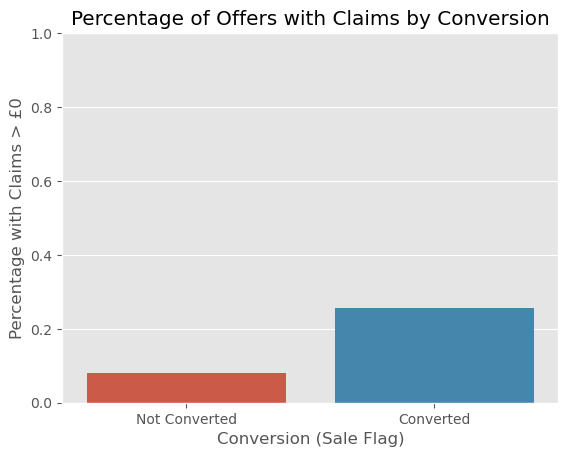

In [90]:
# Barplot of percentage of offers with claims > 0  by conversion
df['has_claim'] = df['claim_amount'] > 0
conversion_claim_rate = df.groupby('sale_flag')['has_claim'].mean().reset_index()
sns.barplot(x='sale_flag', y='has_claim', data=conversion_claim_rate)
plt.xlabel('Conversion (Sale Flag)')
plt.ylabel('Percentage with Claims > £0')
plt.title('Percentage of Offers with Claims by Conversion')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.ylim(0, 1)

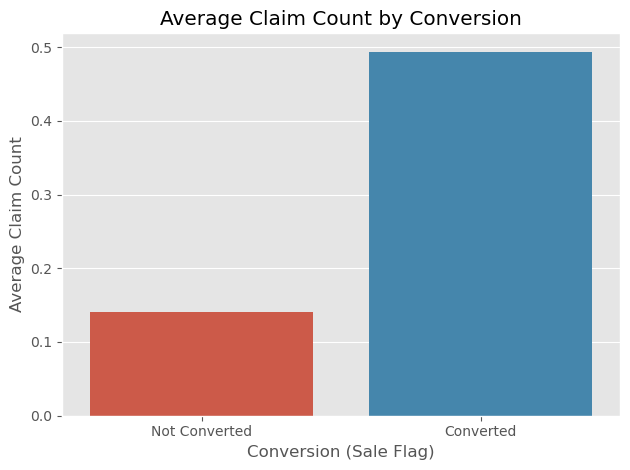

In [93]:
# Barplot of average Claim Count per Sale Flag
avg_claim_count = df.groupby('sale_flag')['claims_count'].mean().reset_index()
sns.barplot(x='sale_flag', y='claims_count', data=avg_claim_count)
plt.xlabel('Conversion (Sale Flag)')
plt.ylabel('Average Claim Count')
plt.title('Average Claim Count by Conversion')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.tight_layout()

In [ ]:
# logistic regression to predict sale_flag based on claim_amount and claims_count
df_model = df[['sale_flag', 'claim_amount', 'claims_count']].copy()
df_model['claims_count'] = df_model['claims_count'].astype(float) 
np.asarray(df_model)

# Add constant value for intercept
X = sm.add_constant(df_model[['claim_amount', 'claims_count']])
y = df_model['sale_flag']

# Logistic Regression Model
model = sm.Logit(y, X).fit()

# Summary Output
print(model.summary())
odds_ratios = np.exp(model.params)
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.517055
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              sale_flag   No. Observations:                 8866
Model:                          Logit   Df Residuals:                     8863
Method:                           MLE   Df Model:                            2
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                 0.02898
Time:                        17:15:20   Log-Likelihood:                -4584.2
converged:                       True   LL-Null:                       -4721.0
Covariance Type:            nonrobust   LLR p-value:                 3.829e-60
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.3747      0.027    -50.008      0.000      -1.429      -1.321
claim_amount    -0.0013

[[6794   82]
 [1892   98]]
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87      6876
         1.0       0.54      0.05      0.09      1990

    accuracy                           0.78      8866
   macro avg       0.66      0.52      0.48      8866
weighted avg       0.73      0.78      0.70      8866

ROC-AUC Score: 0.59


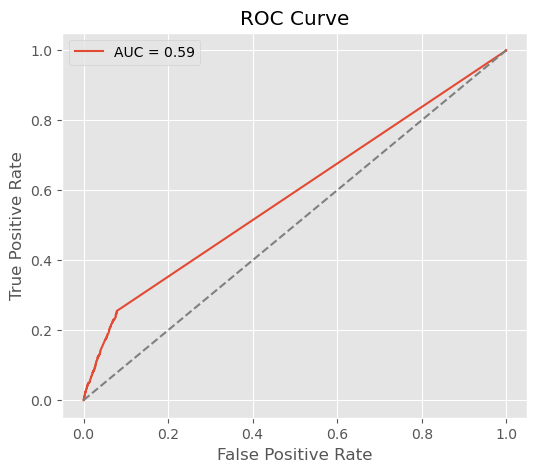

In [96]:
# Predict probabilities and labels
df_model['pred_prob'] = model.predict()
df_model['pred_label'] = (df_model['pred_prob'] >= 0.5).astype(int)

# Confusion Matrix & Report
print(confusion_matrix(df_model['sale_flag'], df_model['pred_label']))
print(classification_report(df_model['sale_flag'], df_model['pred_label']))

# ROC-AUC Score
roc_auc = roc_auc_score(df_model['sale_flag'], df_model['pred_prob'])
print(f"ROC-AUC Score: {roc_auc:.2f}")

# ROC Curve Plot
fpr, tpr, thresholds = roc_curve(df_model['sale_flag'], df_model['pred_prob'])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Model showed that claim count is a clear positive predictor of conversion—each extra claim nearly doubles the chance a customer will accept an offer. Claim amount has a small negative effect, but it doesn’t change much in practice. The model explains only a small part of conversion decisions (Pseudo R² = 0.029). The ROC curve confirmed this, with an AUC of 0.59, meaning the model’s predictions are only slightly better than random.

This shows claims history helps, but it must be used together with other factors for better results.

## Final Recommendation

Based on the analysis, the @22% and @23% pricing strategies apply different price changes, but this does not significantly affect conversion rates. Both strategies show similar price elasticity (-0.43: 1% increase in price leads to a 0.43% drop in conversion), indicating that customer sensitivity to price changes is stable. However, the @22% strategy generates more revenue per sale (12.24 uplift over Base Rate) without losing conversions (Chi-square test), making it a better choice for maximizing revenue. I recommend continuing with the @22% strategy. Additionally, testing other uplifts lower or higher (specially for older product), could show if reducing prices further might boost conversions. The pricing model should keep focusing on revenue while remaining within customer price tolerance.

This part shows interesting insights, for @22% model Mid-price range (48–69) can absorb price increases with positive conversion impact so it is a good test to go for higher prices in this area. @23% has same situation but for lower range (45.6, 48.12)

Another Suggestion is working on Inside group Elasticities, for instance in this are (£48.24 - £69.48) price changes boosts conversion

Other suggestion is to look into how claims affect business since customers with more claims may provide better chances to increase revenue while keeping them. Each extra claim almost doubles the chances of offer acceptance. 

Another important area to improve is the customer experience, particularly for large claim amounts. These customers often turn down offers more frequently. 

Other ideas include examining the effects of "plans active" and "plans cancelled.

should also include the "predicted_conversion_rate" to get a clearer view of how well the model’s conversion predictions match real results. 

Since most quotes are for new customers, it would make sense to focus more on improving offers for this group.



